In [1]:
!pip install --user --upgrade google-cloud-bigquery

In [2]:
!pip install --user --upgrade google-cloud-monitoring

In [3]:
!pip install --upgrade google-cloud-bigquery-storage

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

In [6]:
from google.cloud import bigquery

In [7]:
client = bigquery.Client()

In [8]:
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE DEP_DELAY >= 10 AND RAND() < 0.01
"""
df = client.query(sql).to_dataframe()
df.describe()

,ARR_DELAY,DEP_DELAY
count,12664.000000,12724.000000
mean,47.055512,51.490883
std,64.675159,62.089372
min,-42.000000,10.000000
25%,11.000000,17.000000
50%,27.000000,30.000000
75%,60.000000,61.000000
max,1199.000000,1198.000000


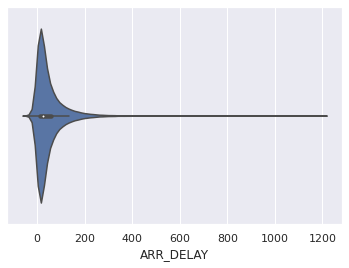

In [9]:
sns.set_style("whitegrid")
sns.set(font="DejaVu Sans")
ax = sns.violinplot(data=df, 
    x='ARR_DELAY', inner='box', orient='h')

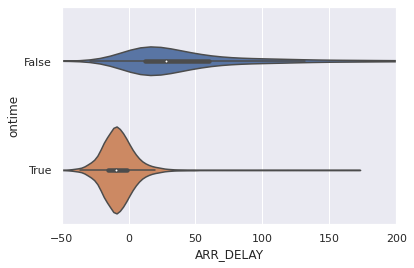

In [10]:
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001
"""
df = client.query(sql).to_dataframe()
df['ontime'] = df['DEP_DELAY'] < 10
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime',
    inner='box', orient='h')
ax.set_xlim(-50, 200);

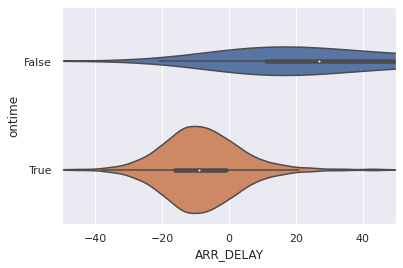

In [11]:
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001
"""
df = client.query(sql).to_dataframe()
df['ontime'] = df['DEP_DELAY'] < 10
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime',
                    inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 50);

In [12]:
%%bigquery
#standardsql
SELECT
  AVG(ARR_DELAY) AS arrival_delay
FROM
  `flights.tzcorr`
GROUP BY
  DEP_DELAY
ORDER BY
  DEP_DELAY

Downloading: 100%|██████████| 1218/1218 [00:00<00:00, 1366.70rows/s]


,arrival_delay
0,NaN
1,-80.0
2,-87.0
3,-77.0
4,-26.0
...,...
1213,1638.0
1214,1636.0
1215,1665.0
1216,1898.0


In [13]:
%%bigquery
#standardsql
SELECT
  DEP_DELAY,
  AVG(ARR_DELAY) AS arrival_delay,
  COUNT(ARR_DELAY) AS numflights
FROM
  `flights.tzcorr`
GROUP BY
  DEP_DELAY
ORDER BY
  DEP_DELAY

Downloading: 100%|██████████| 1218/1218 [00:00<00:00, 1258.63rows/s]


,DEP_DELAY,arrival_delay,numflights
0,NaN,NaN,0
1,-82.0,-80.0,1
2,-68.0,-87.0,1
3,-61.0,-77.0,1
4,-56.0,-26.0,1
...,...,...,...
1213,1631.0,1638.0,1
1214,1649.0,1636.0,1
1215,1670.0,1665.0,1
1216,1878.0,1898.0,1


In [14]:
%%bigquery
#standardsql
SELECT
  AVG(DEP_DELAY) - 3*STDDEV(DEP_DELAY) AS filtermin,
  AVG(DEP_DELAY) + 3*STDDEV(DEP_DELAY) AS filtermax
FROM
  `flights.tzcorr`

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.06rows/s]


,filtermin,filtermax
0,-101.872669,120.612986


In [15]:
%%bigquery
#standardsql
SELECT
  APPROX_QUANTILES(DEP_DELAY, 20)
FROM
  `flights.tzcorr`

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.14rows/s]


,f0_
0,"[-82.0, -9.0, -7.0, -6.0, -5.0, -5.0, -4.0, -3..."


In [16]:
%%bigquery
#standardsql
SELECT
  DEP_DELAY,
  AVG(ARR_DELAY) AS arrival_delay,
  STDDEV(ARR_DELAY) AS stddev_arrival_delay,
  COUNT(ARR_DELAY) AS numflights
FROM
  `flights.tzcorr`
GROUP BY
  DEP_DELAY
HAVING
  numflights > 370
ORDER BY
  DEP_DELAY

Downloading: 100%|██████████| 240/240 [00:01<00:00, 234.02rows/s]


,DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights
0,-23.0,-23.888646,11.432163,458
1,-22.0,-23.227488,12.590133,633
2,-21.0,-22.299781,11.558313,914
3,-20.0,-21.407821,12.066489,1432
4,-19.0,-20.430769,11.910134,1950
...,...,...,...,...
235,212.0,209.266667,22.062675,390
236,214.0,209.973190,19.721838,373
237,215.0,211.614078,19.652061,412
238,217.0,214.189258,19.893176,391


In [17]:
%%bigquery
#standardSQL
SELECT COUNT(arr_delay)
FROM `flights.tzcorr`

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.21rows/s]


,f0_
0,5714008


In [18]:
%%bigquery
#standardsql
SELECT
  (5714008 - SUM(numflights)) AS num_removed,
  AVG(arrival_delay * numflights)/AVG(DEP_DELAY * numflights) AS lm
FROM (
  #standardsql
SELECT
  DEP_DELAY,
  AVG(ARR_DELAY) AS arrival_delay,
  COUNT(ARR_DELAY) AS numflights
FROM
  `flights.tzcorr`
GROUP BY
  DEP_DELAY
ORDER BY
  DEP_DELAY
)
WHERE
  numflights > 1000

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.19rows/s]


,num_removed,lm
0,70802,0.248472


In [19]:
depdelayquery = """
SELECT
  DEP_DELAY,
  arrival_delay,
  stddev_arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr`
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY
"""
depdelay = client.query(depdelayquery).to_dataframe()
depdelay.head()

,DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights
0,-23.0,-23.888646,11.432163,458
1,-22.0,-23.227488,12.590133,633
2,-21.0,-22.299781,11.558313,914
3,-20.0,-21.407821,12.066489,1432
4,-19.0,-20.430769,11.910134,1950


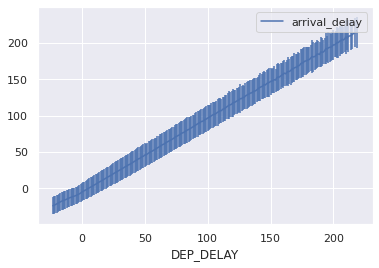

In [20]:
ax = depdelay.plot(kind='line',
    x='DEP_DELAY', y='arrival_delay',
    yerr='stddev_arrival_delay');

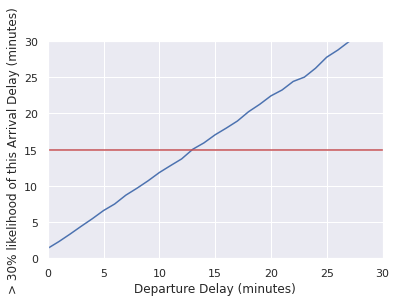

In [21]:
Z_30 = 0.52
depdelay['arr_delay_30'] = (
  (Z_30 * depdelay['stddev_arrival_delay'])
  + depdelay['arrival_delay']
)
ax = plt.axes()
depdelay.plot(kind='line',
    x='DEP_DELAY', y='arr_delay_30',
    ax=ax, ylim=(0, 30),
    xlim=(0, 30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)')
plt.axhline(y=15, color='r');

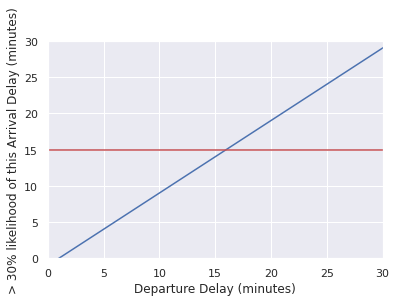

In [22]:
depdelayquery2 = """
SELECT
  DEP_DELAY,
  APPROX_QUANTILES(ARR_DELAY, 101)[OFFSET(70)] AS arrival_delay,
  COUNT(ARR_DELAY) AS numflights
FROM
  `flights.tzcorr`
GROUP BY
  DEP_DELAY
HAVING
  numflights > 370
ORDER BY
  DEP_DELAY
"""
depdelay = client.query(depdelayquery2).to_dataframe()
ax = plt.axes()
depdelay.plot(kind='line',
    x='DEP_DELAY', y='arrival_delay',
    ax=ax, ylim=(0, 30),
    xlim=(0, 30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)')
plt.axhline(y=15, color='r');